# Modelo estatístico para classificação do gênero de uma pessoa baseado em seu primeiro nome

In [157]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import requests

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_curve, precision_recall_curve
from sklearn.model_selection import train_test_split

In [2]:
url = 'https://brasil.io/api/dataset/genero-nomes/nomes/data'
resp = requests.get(url)

In [3]:
def paginate(url):
    resp = requests.get(url).json()
    yield resp['results']
    while resp['next'] is not None:
        resp = requests.get(resp['next']).json()        
        yield resp['results']

In [4]:
names = []
for page in paginate(url):
    names.extend(page)

In [59]:
raw_data = pandas.DataFrame(names)
data = raw_data.loc[:, ['first_name', 'classification']]

## Transform gender columns into integer

In [60]:
data.classification = data.classification.map(lambda x: 1 if x == 'M' else 0)

## Extract features from names

In [124]:
def features(name):
    name = name.lower()
    return {
        'first-letter': name[0],
        'first2-letters': name[:2],
        'first3-letters': name[:3],
        'last-letter': name[-1],
        'last2-letters': name[-2:],
        'last3-letters': name[-3:]
    }

features = np.vectorize(features)

## Train/Test Split - 70/30%

In [125]:
data['features'] = features(data['first_name'])

In [126]:
transformed = vectorizer.fit_transform(data['features'])

In [169]:
X_train, X_test, y_train, y_test = train_test_split(transformed, data['classification'], test_size=0.3)

## Logistic Regression

In [170]:
model = LogisticRegression()
model.fit(X_train, y_train)

/home/rhenanbartels/virtualenvs/eleicoes-brasil/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [171]:
preds = model.predict(X_test)
pred_proba = model.predict_proba(X_test)

In [172]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95     16555
           1       0.94      0.93      0.93     13682

    accuracy                           0.94     30237
   macro avg       0.94      0.94      0.94     30237
weighted avg       0.94      0.94      0.94     30237



In [173]:
print(accuracy_score(y_test, preds))

0.9397426993418659


## ROC curve of predictions

In [174]:
fpr, tpr, th = roc_curve(y_test, pred_proba[:, 1])
precision, recall, thresholds = precision_recall_curve(y_test, pred_proba[:, 1])

## Best Cutoff point

In [175]:
thresholds[np.abs(recall - precision).argmin()]

0.47841483385327466

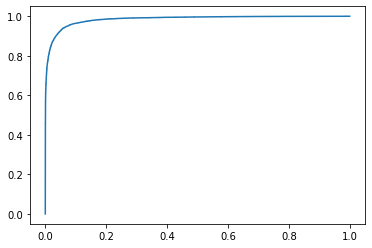

In [176]:
plt.plot(fpr, tpr)

## Persists model and Vectorizer

In [135]:
import pickle
pickle.dump(model, open('modelo_genero_nome.pkl', 'wb'))
pickle.dump(vectorizer, open('vectorizer_genero_nome.pkl', 'wb'))

## Save table with names classfication

In [139]:
data[['first_name', 'classification']].to_csv('classificacao_nomes.csv', index=False, sep=';')